In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import itertools as it
import collections as col
import random
import os
import copy
import json
from tqdm import tqdm
import datetime, time
import seaborn as sns
from collections import defaultdict
import matplotlib
from pathlib import Path
from matplotlib import pyplot as plt
import torch.utils.data as torch_data
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import re
import string
cos = torch.nn.CosineSimilarity(dim=0)
import Levenshtein as le
import torch
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence", output_hidden_states=True)

In [3]:
def corpus_to_sent(corpus):
    with open(corpus, encoding='utf-8') as f:
        reader = f.read().split('# sent_id = ')
    return reader

In [4]:
sents = corpus_to_sent('ru_syntagrus-ud-dev.conllu')

sent_list = []
for sent in sents[1:10]:
    s = sent.split('\n')[1].strip('# text = ')
    s = " ".join(re.findall('[a-zA-Zа-яА-яёЁ]+', s))
    print(s)
    sent_list.append(s) #список предложений без знаков препинания

sent_list[8]

Алгоритм от имени учёного аль Хорезми точный набор инструкций описывающих порядок действий исполнителя для достижения результата решения задачи за конечное время
В старой трактовке вместо слова порядок использовалось слово последовательность но по мере развития параллельности в работе компьютеров слово последовательность стали заменять более общим словом порядок
Это связано с тем что работа каких то инструкций алгоритма может быть зависима от других инструкций или результатов их работы
Таким образом некоторые инструкции должны выполняться строго после завершения работы инструкций от которых они зависят
Независимые инструкции или инструкции ставшие независимыми из за завершения работы инструкций от которых они зависят могут выполняться в произвольном порядке параллельно или одновременно если это позволяют используемые процессор и операционная система
Ранее часто писали алгорифм сейчас такое написание используется редко но тем не менее имеет место например Нормальный алгорифм Маркова
Час

'Единого истинного определения понятия алгоритм нет'

In [4]:
sents = corpus_to_sent('ru_syntagrus-ud-train-a.conllu')

sent_list = []
for sent in sents[1:10]:
    s = sent.split('\n')[1].strip('# text = ')
    s = " ".join(re.findall('[a-zA-Zа-яА-яёЁ]+', s))
    print(s)
    sent_list.append(s) #список предложений без знаков препинания

sent_list[8]

Анкета
Начальник областного управления связи Семен Еремеевич был человек простой приходил на работу всегда вовремя здоровался с секретаршей за руку и иногда даже писал в стенгазету заметки под псевдонимом Муха
В приемной его с утра ожидали посетители кое кто с важными делами а кое кто и с такими которые легко можно было решить в нижестоящих инстанциях не затрудняя Семена Еремеевича
Однако стиль работы Семена Еремеевича заключался в том чтобы принимать всех желающих и лично вникать в дело
Приемная была обставлена просто но по деловому
У двери стоял стол секретарши на столе пишущая машинка с широкой кареткой
В углу висел репродуктор и играло радио для развлечения ожидающих и еще для того чтобы заглушать голос начальника доносившийся из кабинета так как бесспорно среди посетителей могли находиться и случайные люди
Кабинет отличался скромностью присущей Семену Еремеевичу
В глубине стоял широкий письменный стол с бронзовыми чернильницами и перед ним два кожаных кресла


'В глубине стоял широкий письменный стол с бронзовыми чернильницами и перед ним два кожаных кресла'

In [5]:
def ud_to_tree(lines):
        
    colons = [l.split('\t') for l in lines[:-2] if l != '' and l[0].isdigit()]

    words = [c[0] + '_'+ c[1] for c in colons]

    tree = [('0_root', [])]
    for w in words:
        tree.append((w, []))
  
    for c in colons:
        if c[6] != '_': # проверка на эллипсис
            tree[int(c[6])][1].append(tree[int(c[0])]) #[i + 1])
        else:
            return False
    
    return tree

In [6]:
trees = []
sents = corpus_to_sent('ru_syntagrus-ud-dev.conllu')
sent_list = []
data = []

for sent in sents[1:]:
    lines = sent.split('\n')[2:]
    if ud_to_tree(lines):
        trees.append(ud_to_tree(lines))
        s = sent.split('\n')[1].strip('# text = ')
        if re.search('[a-zA-Z]+', s) is None: # проверка на иностранные слова
            if re.search('\d+', s) is None: # проверка на даты
                s = " ".join(re.findall('[а-яА-яёЁ]+', s))
                sent_list.append(s)
                data.append([s, ud_to_tree(lines)])
len(data)

5646

In [7]:
trees = []
sents = corpus_to_sent('ru_syntagrus-ud-train-a.conllu')
sent_list = []
data = []

for sent in sents[1:]:
    lines = sent.split('\n')[2:]
    if ud_to_tree(lines):
        trees.append(ud_to_tree(lines))
        s = sent.split('\n')[1].strip('# text = ')
        if re.search('[a-zA-Z]+', s) is None: # проверка на иностранные слова
            if re.search('\d+', s) is None: # проверка на даты
                s = " ".join(re.findall('[а-яА-яёЁ]+', s))
                sent_list.append(s)
                data.append([s, ud_to_tree(lines)])
len(data)

21118

In [7]:
# перевод в скобочный формат с учетом пунтакционных знаков

def bracketed_format(node):
    res = []
    if len(node[1]) != 0:
        for child in node[1]:
            res.append(bracketed_format(child))
            
        res.append(int(node[0].split('_')[0]))

    else:
        res = int(node[0].split('_')[0])
        
    return res

In [8]:
def recursive_sort(lst):
    for i in range(len(lst)):
        if isinstance(lst[i], list):
            lst[i] = recursive_sort(lst[i])
    
    lst.sort(key=lambda x: x if isinstance(x, int) else x[0])
    
    return lst

# проверка на разрыв нумерации для обнаружения непроективных предложений

def check_num_gap(lst, prev=0):
    for item in lst:
        if isinstance(item, list):
            if check_num_gap(item, prev):
                return True

            prev = item[-1]
            while type(prev) is not int:
                prev = prev[-1]

        elif item - prev > 1:
            return True # если разрыв нумерации обнаружен
        else:
            prev = item
            
    return False # если разрыва нет

# сбор по дереву зависимых, являющихся знаками препинания

def get_punctuation_leaves(node):
    leaves = []
    
    if len(node[1]) != 0:    
        for child in node[1]:
            leaves += get_punctuation_leaves(child)
    else:
        if node[0].split('_')[1] in string.punctuation:
            leaves.append(int(node[0].split('_')[0]))
        
        elif node[0].split('_')[1].isdigit():
            leaves.append(int(node[0].split('_')[0]))
        
        elif node[0].split('_')[1] == '…':
            leaves.append(int(node[0].split('_')[0]))
            
            
    return leaves 

# избавление от индексов пунктационных знаков

def get_rid_of_puncts(lst, puncts):
    i = 0
    while i  < len(lst):
        if isinstance(lst[i], list):
            get_rid_of_puncts(lst[i], puncts)
                
        elif isinstance(lst[i], int) and lst[i] in puncts:
            lst.pop(i)
            i -= 1
            
        if isinstance(lst[i], list) and len(lst[i]) == 1:
            lst[i] = lst[i][0]
            
        i += 1
            
    return lst

def num_in_order(lst, prev=0):
#     i = 0
    for i in range(len(lst)):
        
        if isinstance(lst[i], list):
            num_in_order(lst[i], prev)
            
            prev = lst[i][-1]
            while type(prev) is not int:
                prev = prev[-1]
            prev += 1
            
        elif isinstance(lst[i], int):
            lst[i] = prev
            prev += 1
            
    return lst

In [9]:
new_data = []
with_num_gap = []

for d in data:
    notsort = bracketed_format(d[1][0][1][0])
    # к сожалению, не все глубокие случаи вложенности списков удалось учитывать в функции сортировки 
    # [[17, 16], [[20, 22, 21], 19], 18] - такие да
    # [[[24, 26, 25], 23], [[29, 30], [32, 34, 33], 31], 28] - такие нет
    # так как в процессе рекурсии первым элементом вложенного отсортированного списка выступает также список
    try:
        alreadysort = recursive_sort(notsort)
        if not check_num_gap(alreadysort):
            puncts = get_punctuation_leaves(d[1][0][1][0])
            without_punct = get_rid_of_puncts(alreadysort, puncts)
            new_data.append([d[0], num_in_order(without_punct)])
        else:
            with_num_gap.append([d[0], alreadysort])
    except TypeError:
        pass       

print(len(new_data))
print(new_data[:2])
print(len(with_num_gap))
print(with_num_gap[100:150]) # непроективные

4319
[['Алгоритм от имени учёного аль Хорезми точный набор инструкций описывающих порядок действий исполнителя для достижения результата решения задачи за конечное время', [[0, [1, 2, [3, [4, 5]]]], 6, 7, [8, [9, [10, [11, 12], [13, 14, [15, [16, 17]], [18, 19, 20]]]]]]], ['Это связано с тем что работа каких то инструкций алгоритма может быть зависима от других инструкций или результатов их работы', [0, 1, [2, 3, [4, [5, [6, 7, 8]], 9, [10, 11, [12, 13, 14, [15, 16, [17, 18]]]]]]]]]
169
[['Не представляете как это было обидно слышать хотя казалось бы всего лишь дополнительные сутки к трем месяцам', [1, 2, [3, 4, [5, 8], 6, 7, [9, [10, 11], [12, 13, 14], [15, 16], [17, [19, 20, 21]], 18]], 22]], ['И науки было много и юмора достаточно', [1, [2, 4], 3, [5, 6, 7, 8], 9]], ['Да и песни постоянно звучали хорошие', [1, 2, [3, 6], 4, 5, 7]], ['Как это удалось сделать', [1, [2, 4], 3, 5]], ['И им надо отвечать тем же а следовательно заниматься их нуждами и жить их заботами', [1, [2, 4, [5, 6],

In [10]:
# сбор информации о словах на границах клауз и не на границах

def boundary_inf(indexes):
    boundary = []
    non_boundary = []

    for i, y in zip(indexes[:-1], indexes[1:]):
        if i.count(']') == 0 and y.count('[') != 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'\[+', y).group(0)))
            
        elif i.count(']') != 0 and y.count('[') == 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'\]+', i).group(0)))
            
        elif i.count(']') != 0 and y.count('[') != 0:
            boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0]), re.search(r'(\]|\[)+', i + y).group(0)))
            
        else:
            non_boundary.append((int(re.findall(r'\d+', i)[0]), int(re.findall(r'\d+', y)[0])))
            
    return (boundary, non_boundary)

In [11]:
for n in new_data:
    indexes = [el.strip(',') for el in str(n[1]).split(' ')]
    n[1] = boundary_inf(indexes)

In [12]:
for n in with_num_gap:
    indexes = [el.strip(',') for el in str(n[1]).split(' ')]
    n[1] = boundary_inf(indexes)

In [13]:
with_num_gap[:5]

[['Оно уверенно шагнуло даже в разговорную речь и сегодня мы нередко встречаем в газетах и слышим в выступлениях политиков выражения вроде алгоритм поведения алгоритм успеха или даже алгоритм предательства',
  ([(3, 4, '['),
    (7, 8, ']['),
    (13, 14, '['),
    (15, 21, ']['),
    (21, 22, '['),
    (26, 27, '['),
    (31, 32, ']['),
    (37, 16, ']]]]['),
    (17, 18, '['),
    (20, 38, ']]')],
   [(1, 2),
    (2, 3),
    (4, 5),
    (5, 6),
    (6, 7),
    (8, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (12, 13),
    (14, 15),
    (22, 23),
    (23, 24),
    (24, 25),
    (25, 26),
    (27, 28),
    (28, 29),
    (29, 30),
    (30, 31),
    (32, 33),
    (33, 34),
    (34, 35),
    (35, 36),
    (36, 37),
    (16, 17),
    (18, 19),
    (19, 20)])],
 ['Одной из самых популярных альпийских вершин среди альпинистов является Гран Жорас расположенная в районе Монблана в верховьях ущелья Лешо',
  ([(1, 2, '['),
    (2, 3, '['),
    (4, 7, '['),
    (8, 5, ']]'),
    (6, 9, ']]'),

In [21]:
new_data[:4]

[['Алгоритм от имени учёного аль Хорезми точный набор инструкций описывающих порядок действий исполнителя для достижения результата решения задачи за конечное время',
  ([(0, 1, '['),
    (2, 3, '['),
    (3, 4, '['),
    (5, 6, ']]]]'),
    (7, 8, '['),
    (8, 9, '['),
    (9, 10, '['),
    (10, 11, '['),
    (12, 13, ']['),
    (14, 15, '['),
    (15, 16, '['),
    (17, 18, ']][')],
   [(1, 2),
    (4, 5),
    (6, 7),
    (11, 12),
    (13, 14),
    (16, 17),
    (18, 19),
    (19, 20)])],
 ['Это связано с тем что работа каких то инструкций алгоритма может быть зависима от других инструкций или результатов их работы',
  ([(1, 2, '['),
    (3, 4, '['),
    (4, 5, '['),
    (5, 6, '['),
    (8, 9, ']]'),
    (9, 10, '['),
    (11, 12, '['),
    (14, 15, '['),
    (16, 17, '[')],
   [(0, 1),
    (2, 3),
    (6, 7),
    (7, 8),
    (10, 11),
    (12, 13),
    (13, 14),
    (15, 16),
    (17, 18)])],
 ['Таким образом некоторые инструкции должны выполняться строго после завершения работы 

In [18]:
def vectors_for_word_all_layers(s):
    encoded_input = tokenizer(s, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Получаем все скрытые состояния (13 слоев: embedding + 12 transformer layers)
    hidden_states = model_output.hidden_states
    
    # Для каждого слоя (пропускаем первый слой - embeddings)
    all_layers_res = []
    for layer in range(1, 13):  # 1-12 слои
        layer_output = hidden_states[layer]
        res = []
        words = s.split(' ')
        for i in range(len(words)):
            inf = encoded_input.word_to_tokens(i)
            if inf is None:  # если слово было разбито на подтокены, которые выходят за пределы max_length
                continue
            start = inf.start
            end = inf.end
            embeds = []
            for _ in range(start, end):
                embeds.append(layer_output[0][_])
            
            if len(embeds) == 1:
                res.append(embeds[0])
            else:
                mean = torch.mean(torch.vstack(embeds), dim=0)
                res.append(mean)
        all_layers_res.append(res)
    
    return all_layers_res  # возвращает список из 12 элементов (по слоям), каждый элемент - список векторов слов

In [22]:
# Функция для вычисления косинусной близости
def cos(v1, v2):
    return torch.nn.functional.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()

# Собираем данные для всех слоев
all_layers_boundary = [defaultdict(list) for _ in range(12)]  # 12 слоев
for n in new_data[:1000]:
    text = n[0]
    words = text.split(' ')
    all_layers_vectors = vectors_for_word_all_layers(text)
    
    for layer in range(12):
        layer_vectors = all_layers_vectors[layer]
        
        # Создаем словарь для хранения информации о скобках между словами
        bracket_pairs = {}
        
        # Сначала обрабатываем слова со скобками между ними
        if len(n[1][0]) != 0:  # слова на границах клауз
            for i in n[1][0]:
                # Добавляем информацию о скобках между словами i[0] и i[1]
                bracket_pairs[(i[0], i[1])] = i[2]
        
        # Теперь анализируем пары слов через одно слово
        for i in range(len(words) - 2):
            j = i + 2  # слово через одно
            
            # Проверяем, что оба слова есть в векторах
            if i >= len(layer_vectors) or j >= len(layer_vectors):
                continue
            
            # Определяем тип скобок между словами i и j
            bracket_type = '0'  # по умолчанию нет скобок
            
            # Проверяем есть ли скобки между i и i+1 или между i+1 и j
            if (i, i+1) in bracket_pairs:
                bracket_type = bracket_pairs[(i, i+1)]
            elif (i+1, j) in bracket_pairs:
                bracket_type = bracket_pairs[(i+1, j)]
            
            # Вычисляем косинусную близость
            output = cos(layer_vectors[i], layer_vectors[j])
            
            # Сохраняем результат с учетом типа скобок
            all_layers_boundary[layer][bracket_type].append(output)
        
        # Дополнительно сохраняем оригинальные пары из n[1][1] (без скобок)
        if len(n[1][1]) != 0:
            for i in n[1][1]:
                if i[0] < len(layer_vectors) and i[1] < len(layer_vectors):
                    output = cos(layer_vectors[i[0]], layer_vectors[i[1]])
                    all_layers_boundary[layer]['0'].append(output)

In [32]:
# Функция для подсчета общего количества скобок (без разбора типов)
def count_brackets(b_type):
    if b_type == '0':
        return 0
    return len(b_type)  # Просто считаем все символы в строке скобок

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


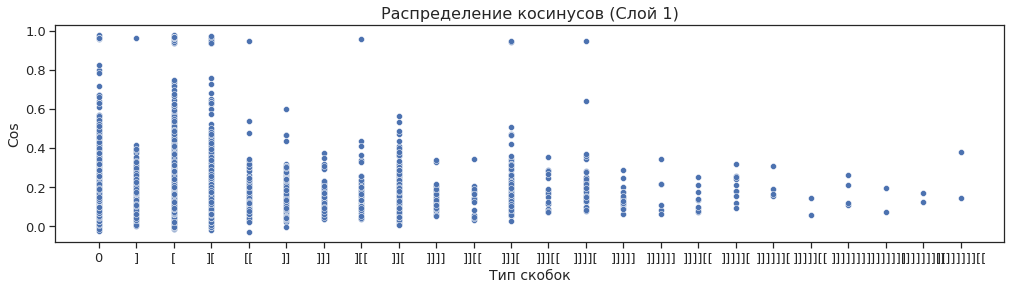

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


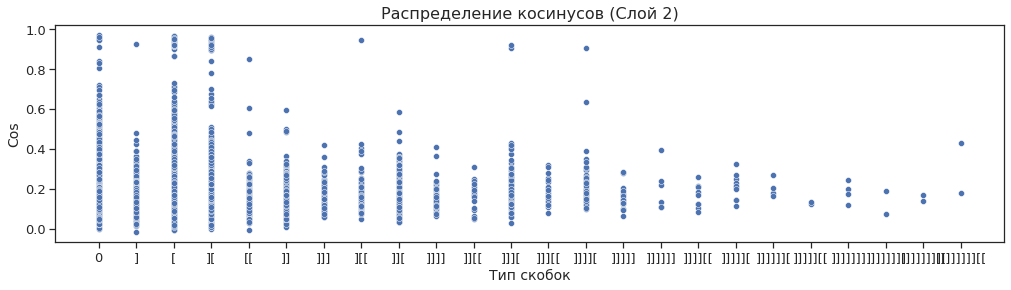

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


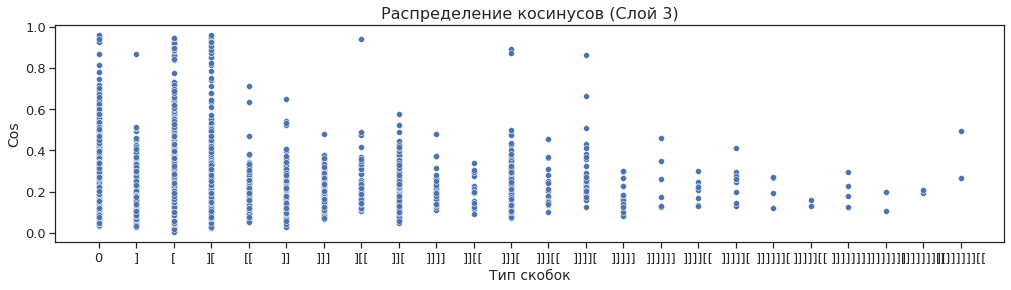

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


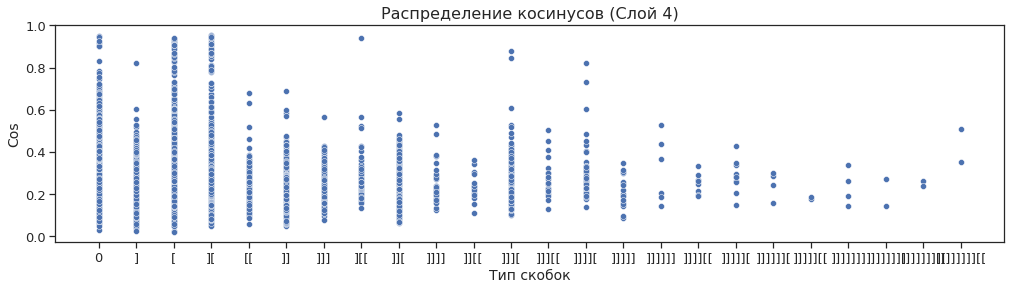

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


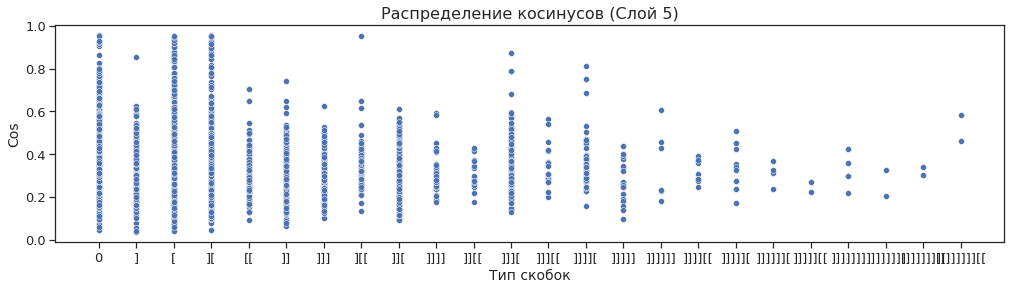

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


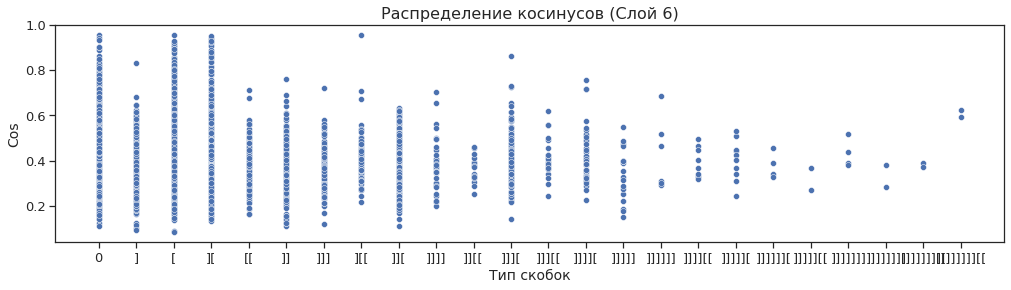

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


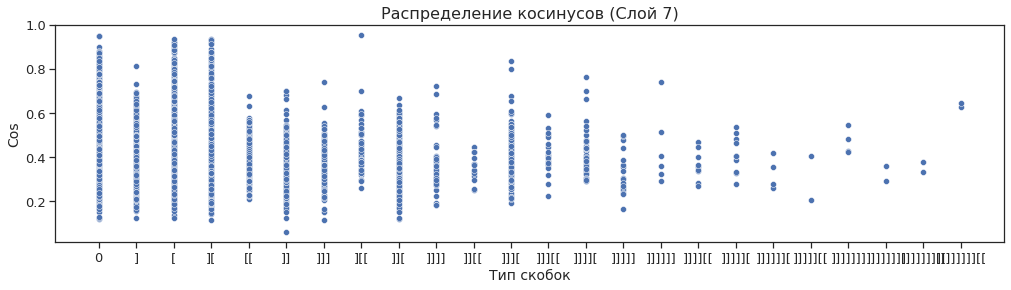

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


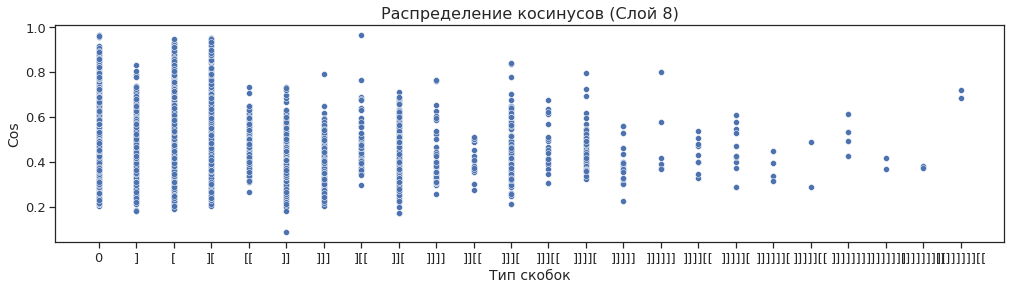

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


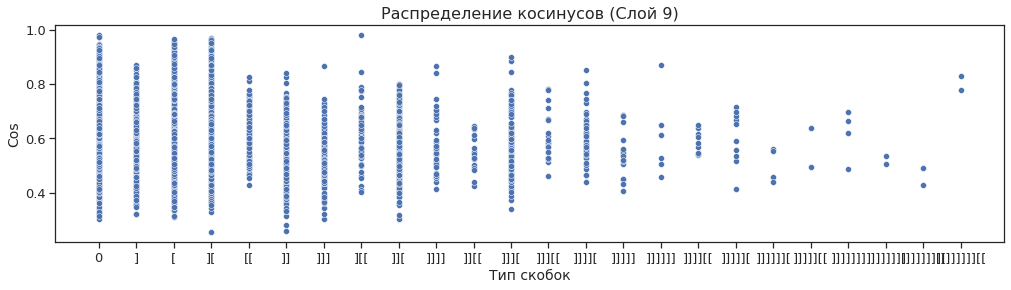

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


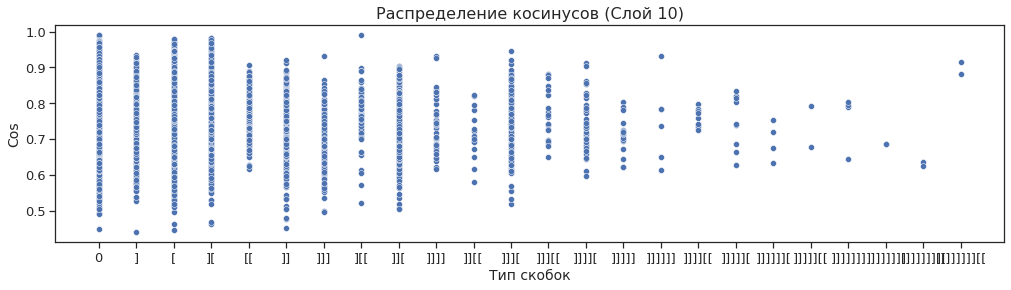

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


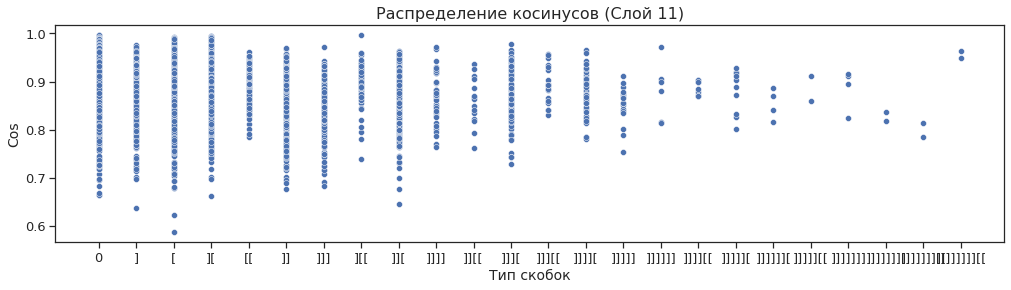

/tmp/ipykernel_202/4213735809.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')


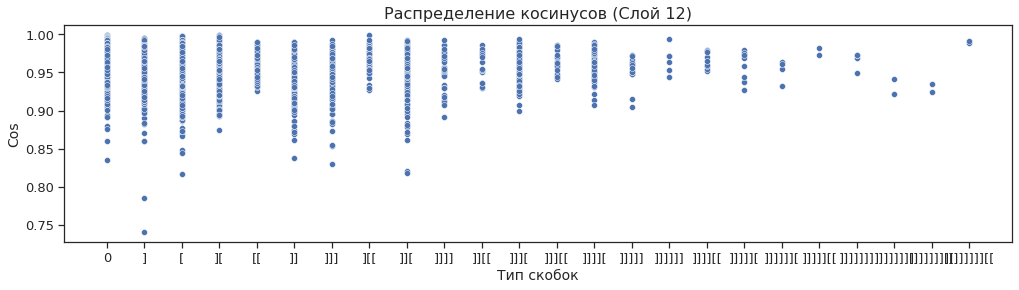

In [33]:
for layer in range(12):
    layer_data = []
    for bracket_type, cos_values in all_layers_boundary[layer].items():
        for val in cos_values:
            layer_data.append({'bracket_type': bracket_type, 'cos': val})
    
    if not layer_data:
        continue
        
    result = pd.DataFrame(layer_data)
    result['bracket_count'] = result['bracket_type'].apply(count_brackets)
    
    # Сортируем данные по количеству скобок
    result = result.sort_values('bracket_count')
    plt.figure(figsize=(17, 4))
    ax = sns.scatterplot(data=result, x="bracket_type", y="cos", palette='vlag')
    ax.set_ylabel("Cos", fontsize=14)
    ax.set_xlabel("Тип скобок", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.title(f'Распределение косинусов (Слой {layer+1})', fontsize=16)
    plt.savefig(f'graphs_linear1_small/scatt_layer_linear1_{layer+1}.png')
    plt.show()

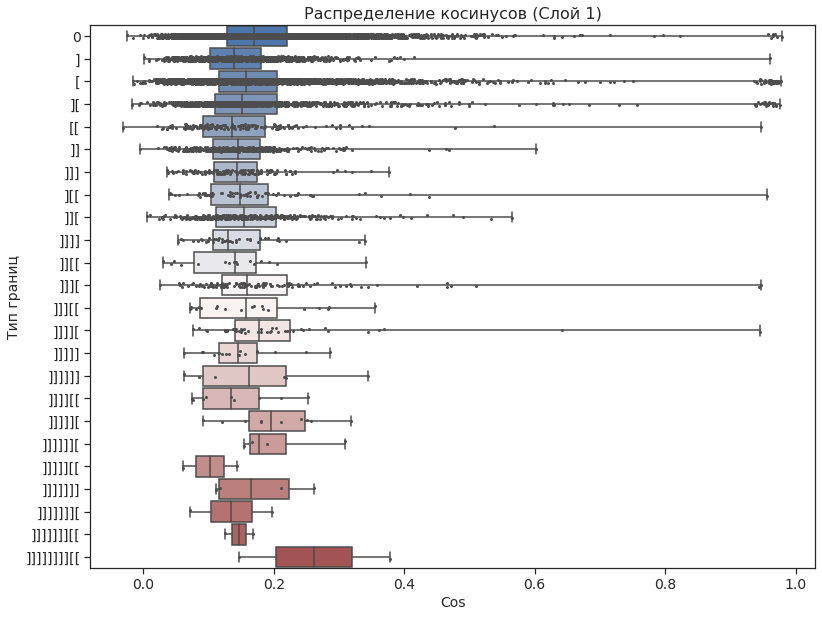

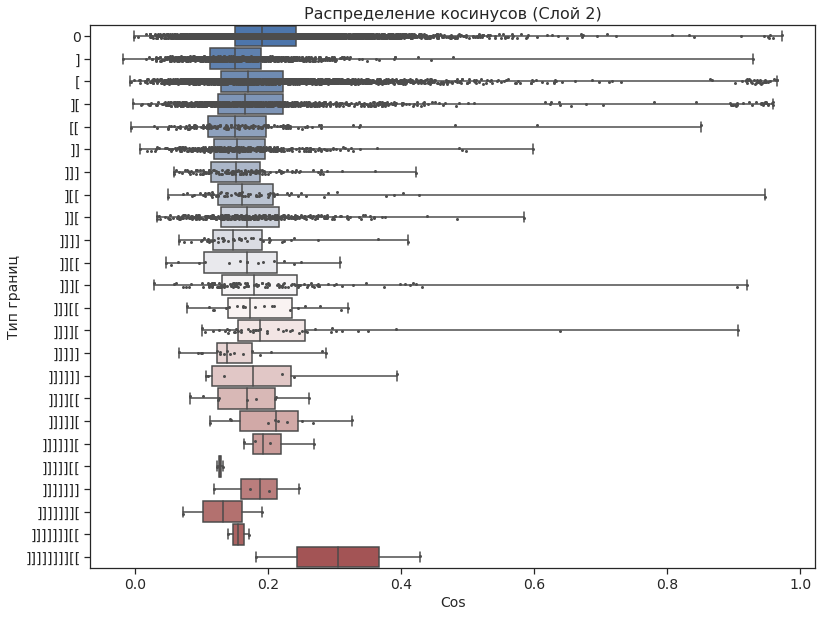

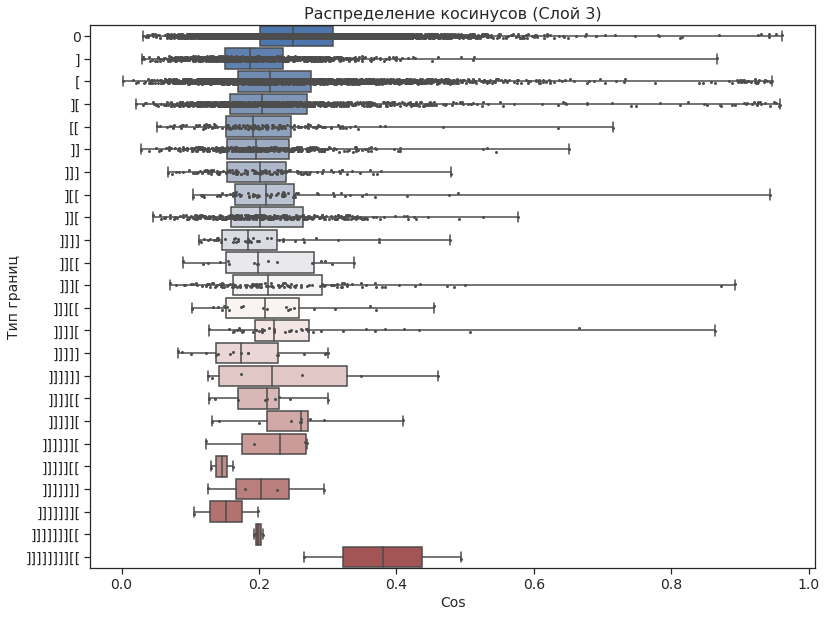

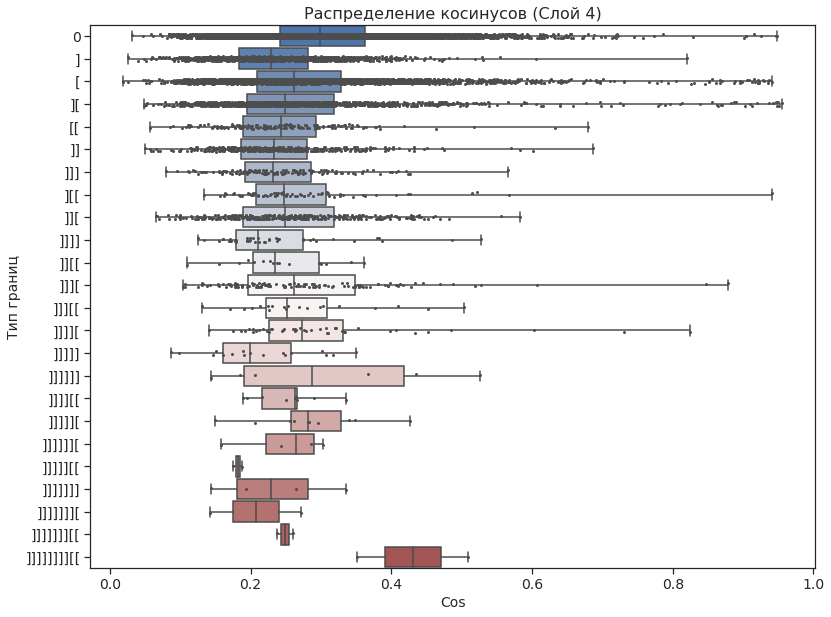

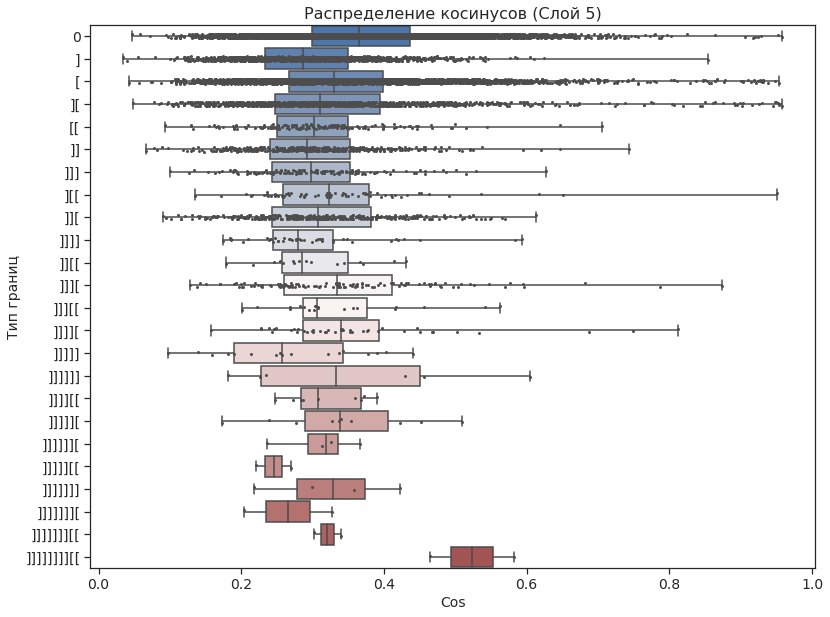

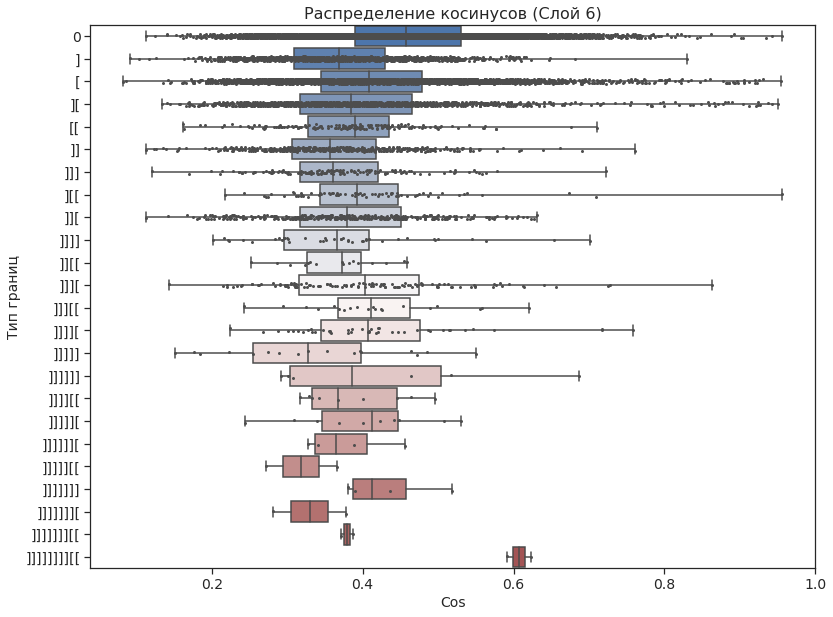

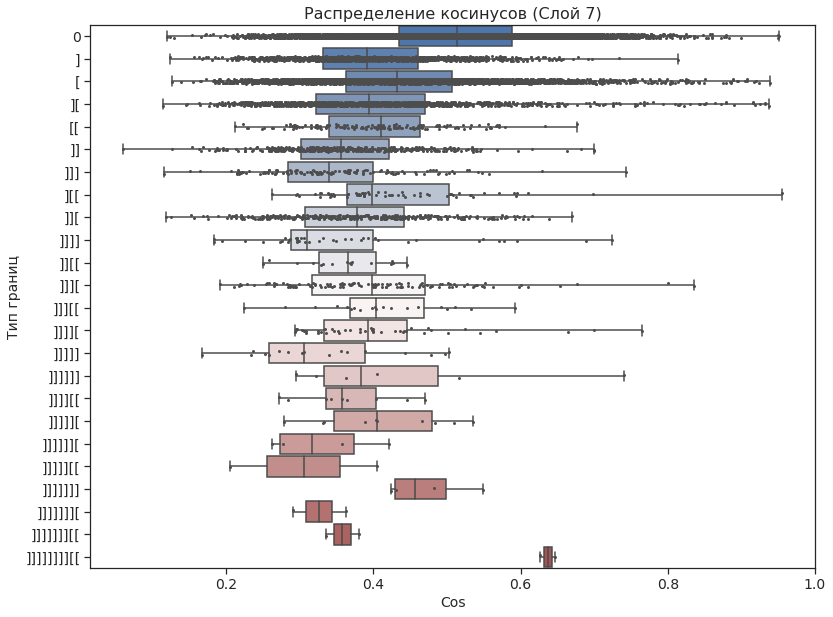

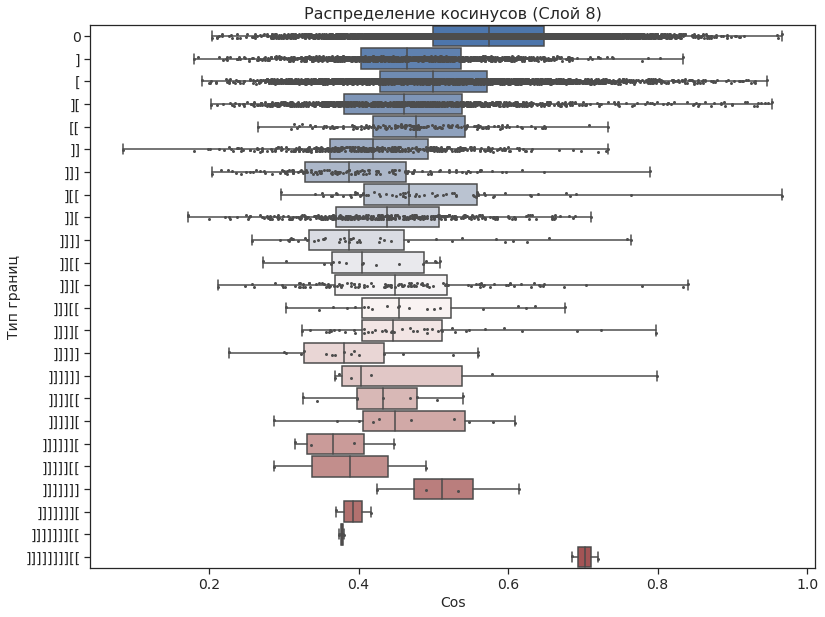

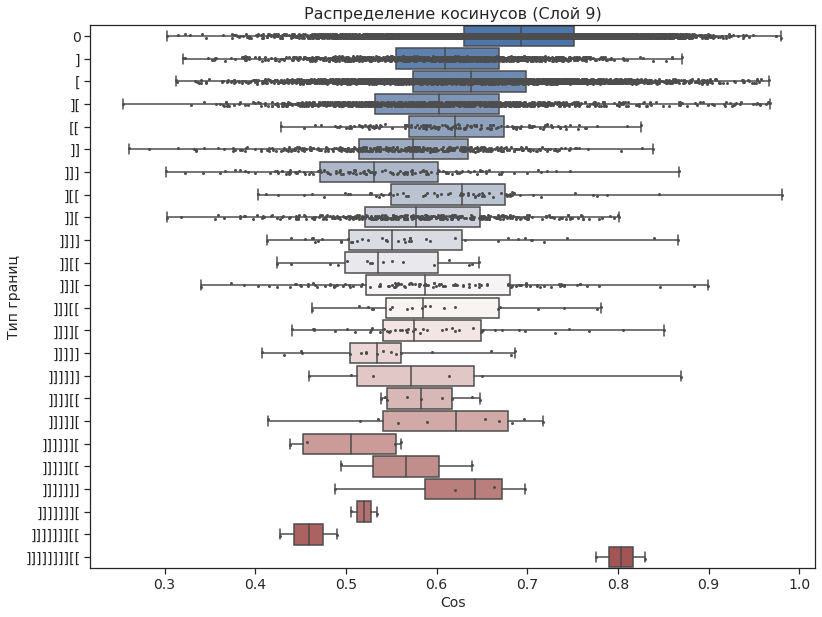

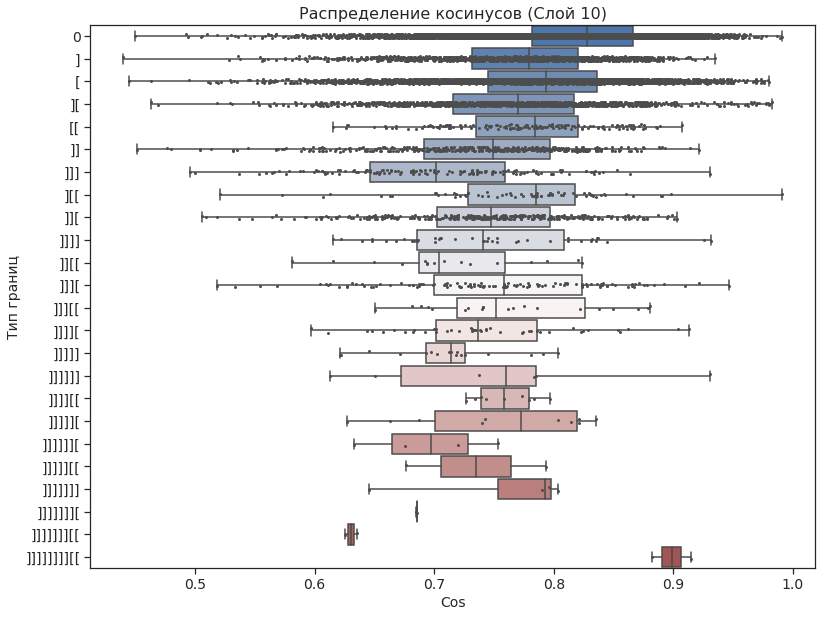

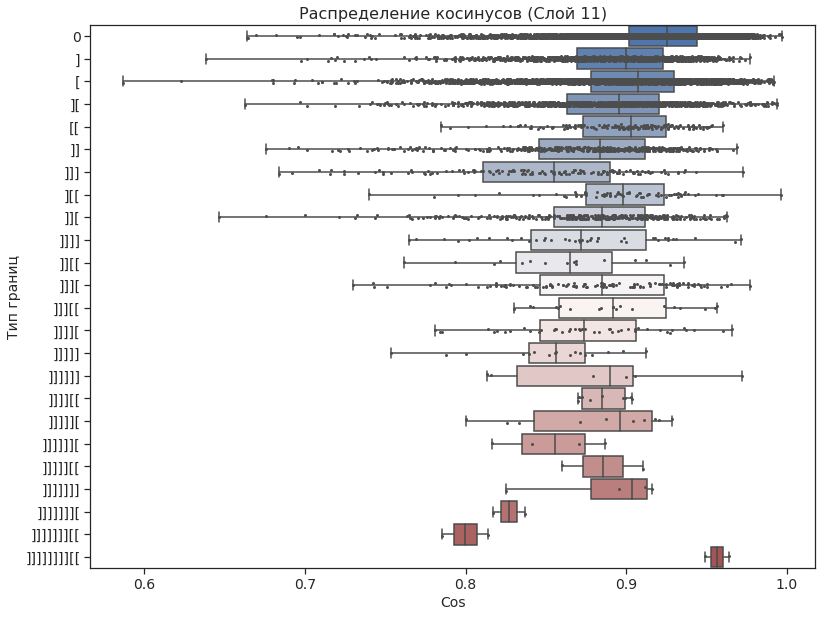

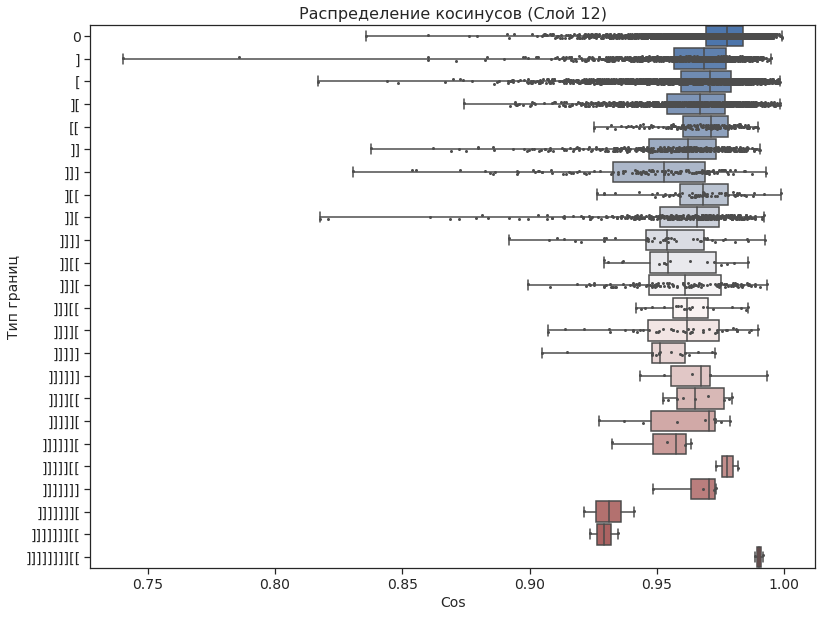

In [34]:

sns.set_theme(style="ticks")

# Создаем 12 графиков (по одному на каждый слой)
for layer in range(12):
    # Преобразуем данные для текущего слоя в DataFrame
    layer_data = []
    for bracket_type, cos_values in all_layers_boundary[layer].items():
        for val in cos_values:
            layer_data.append({'bracket_type': bracket_type, 'cos': val})
    
    if not layer_data:  # если нет данных для этого слоя
        continue
        
    result = pd.DataFrame(layer_data)
    result['bracket_count'] = result['bracket_type'].apply(count_brackets)
    
    # Сортируем данные по количеству скобок
    result = result.sort_values('bracket_count')
    # Создаем фигуру для текущего слоя
    f, ax = plt.subplots(figsize=(13, 10))
    
    # Boxplot
    sns.boxplot(x="cos", y="bracket_type", data=result,
               whis=[0, 100], width=.9, palette="vlag")
    
    # Stripplot (точечный график поверх boxplot)
    sns.stripplot(x="cos", y="bracket_type", data=result,
                  size=3, color=".3", linewidth=0)
    
    # Настройки осей и заголовка
    plt.xlabel('Cos', fontsize=14)
    plt.ylabel('Тип границ', fontsize=14)
    plt.title(f'Распределение косинусов (Слой {layer+1})', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Сохраняем и показываем график
    plt.savefig(f'graphs_linear1_small/boxplot_layer_linear1_{layer+1}.png')
    plt.show()

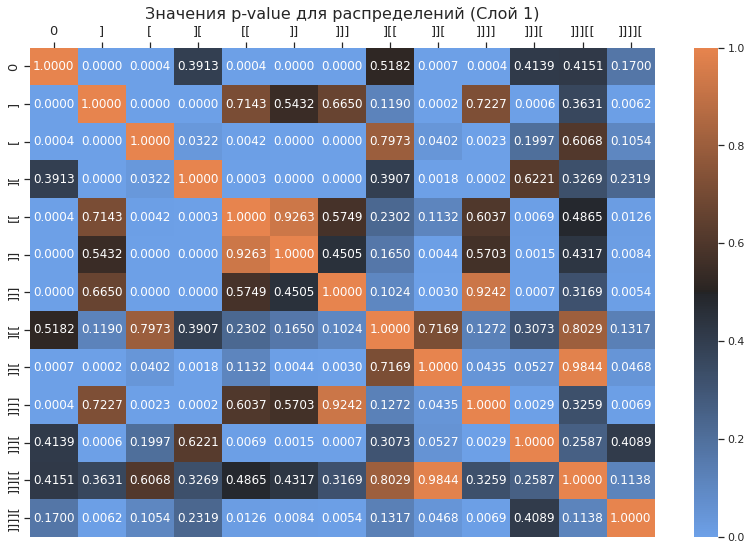

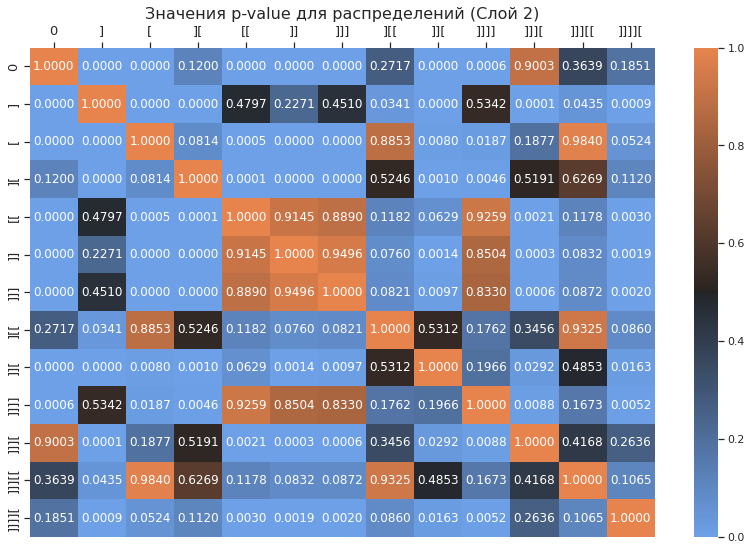

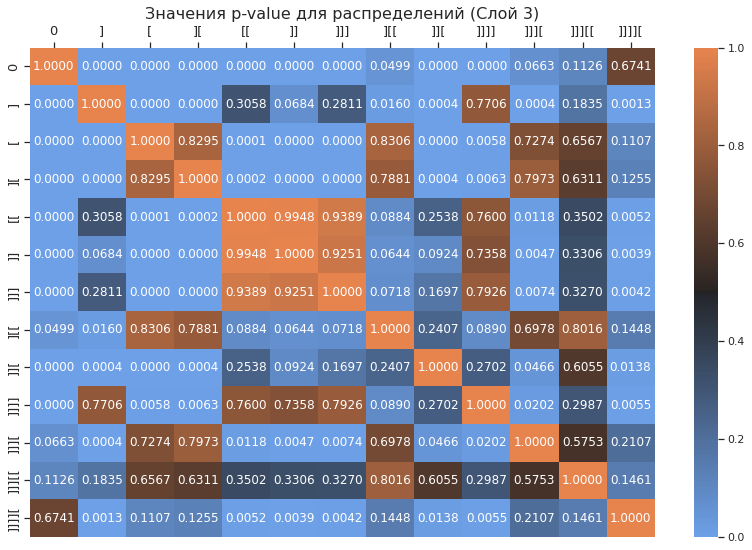

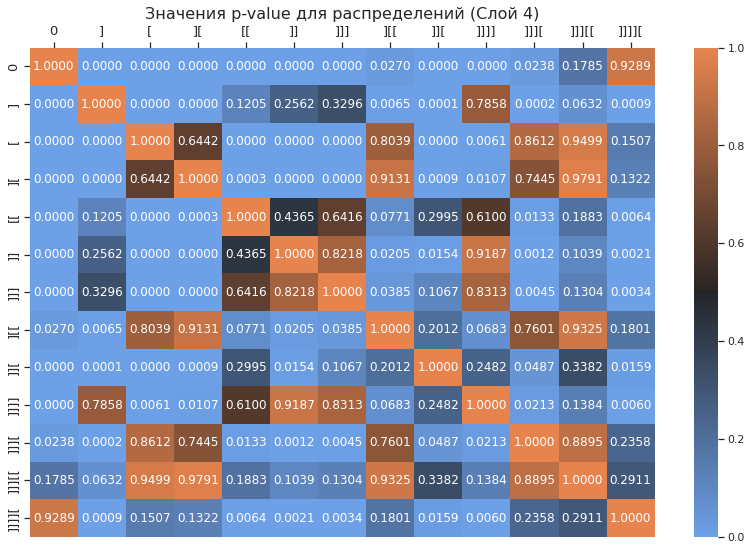

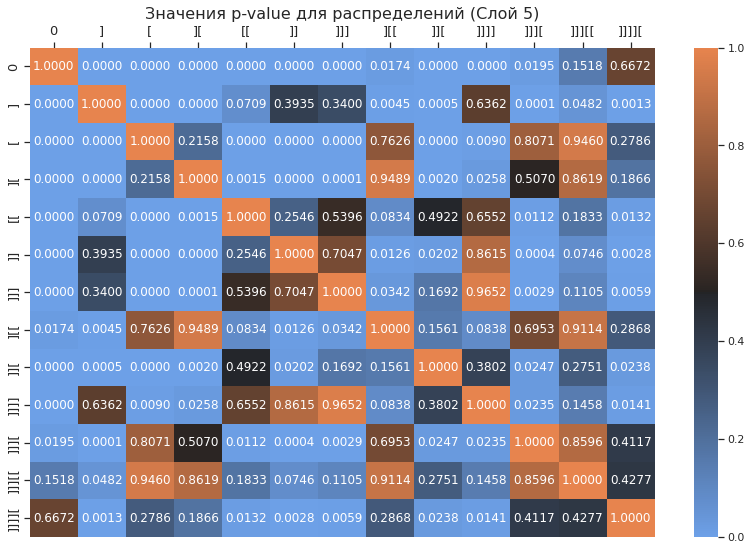

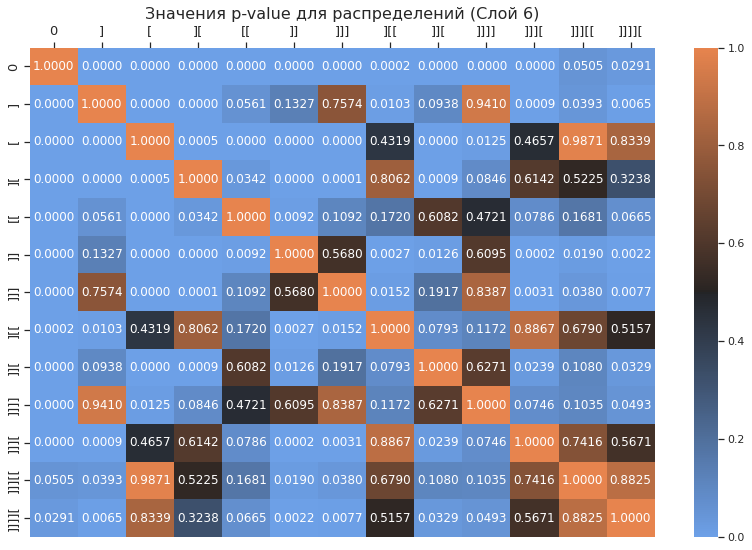

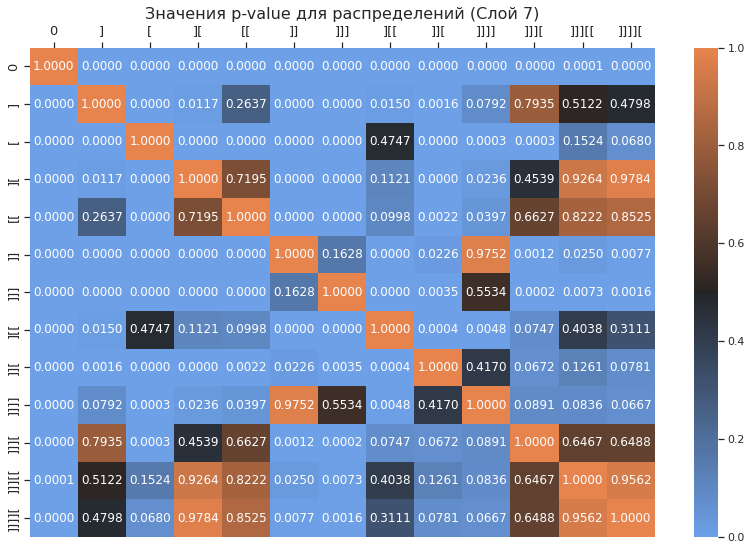

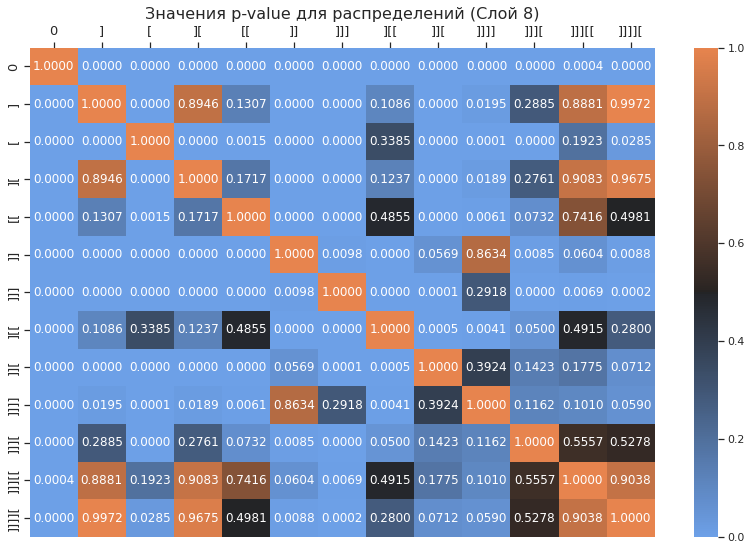

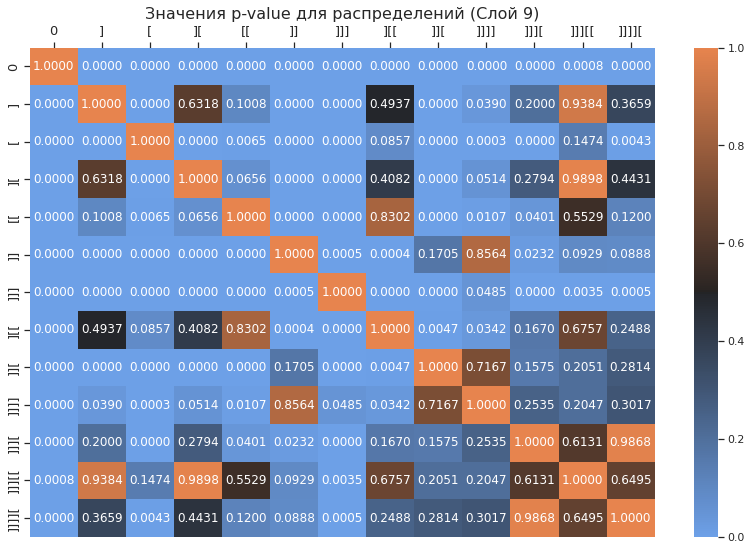

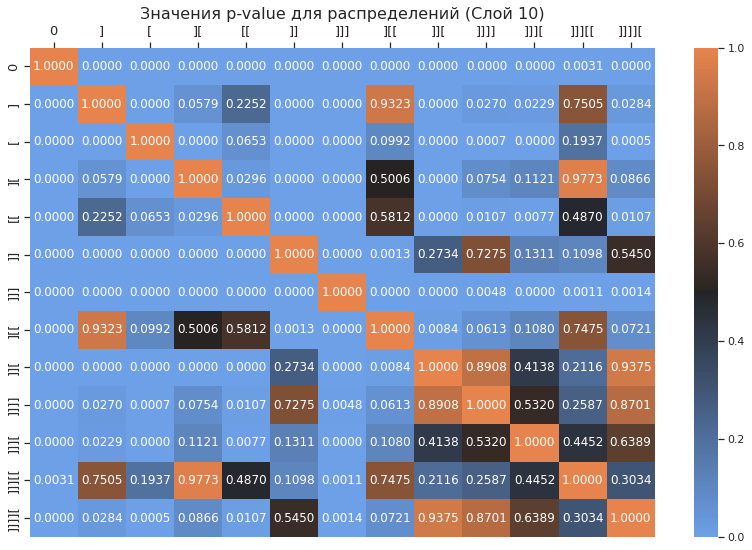

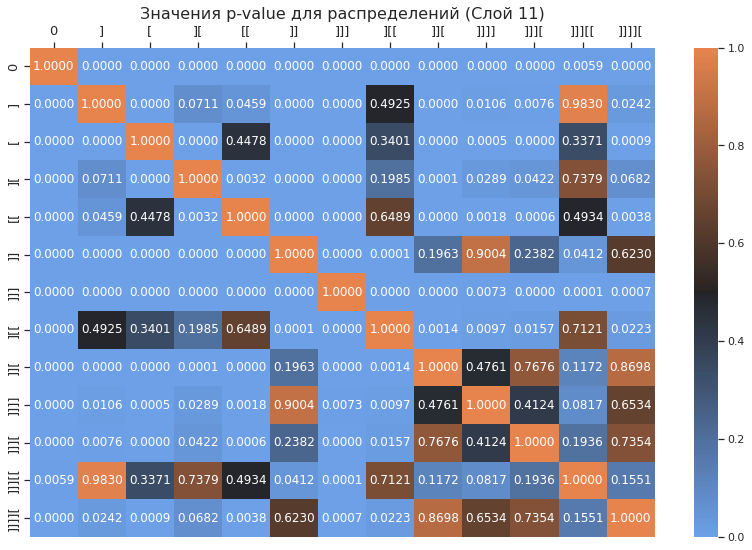

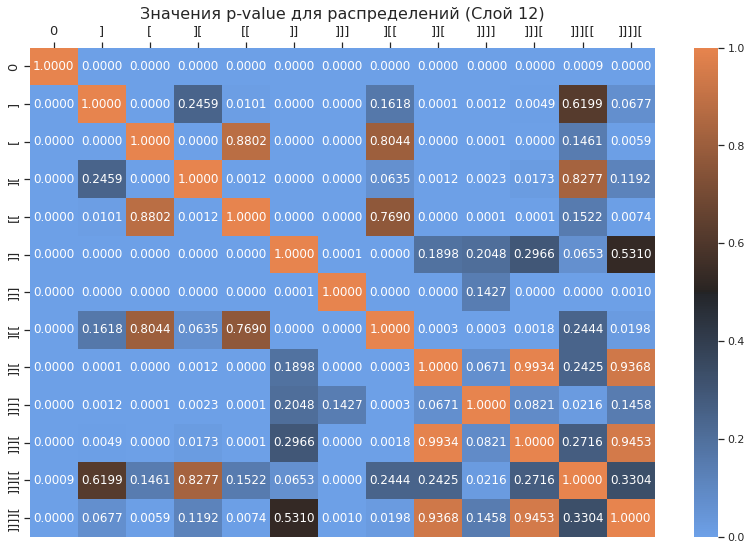

In [35]:
# Создаем heatmap для каждого слоя
for layer in range(12):
    # Подготавливаем данные для текущего слоя
    layer_data = []
    for bracket_type, cos_values in all_layers_boundary[layer].items():
        for val in cos_values:
            layer_data.append({'bracket_type': bracket_type, 'cos': val})
    
    if not layer_data:  # пропускаем слой, если нет данных
        continue
        
    result = pd.DataFrame(layer_data)
    result['bracket_count'] = result['bracket_type'].apply(count_brackets)
    
    # Сортируем данные по количеству скобок
    result = result.sort_values('bracket_count')    
    # Собираем статистику по группам
    inf_for_stats = {}
    for bracket in result.bracket_type.unique():
        group = result[result['bracket_type'] == bracket]
        if len(group['cos']) >= 20:  # только если достаточно данных
            inf_for_stats[bracket] = group['cos']
    
    if not inf_for_stats:  # если нет групп с достаточным количеством данных
        continue
    
    # Вычисляем p-values для всех пар групп
    arr = []
    for k1 in inf_for_stats.keys():
        row = []
        for k2 in inf_for_stats.keys():
            row.append(stats.ttest_ind(a=inf_for_stats[k1], b=inf_for_stats[k2], equal_var=False)[1])
        arr.append(row)
    
    pvalues = np.array(arr)
    table = pd.DataFrame(data=pvalues, index=inf_for_stats.keys(), columns=inf_for_stats.keys())
    
    # Строим heatmap
    plt.figure(figsize=(14, 9))
    ax = sns.heatmap(
        table, 
        annot=True, 
        fmt=".4f", 
        cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
    )
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.title(f'Значения p-value для распределений (Слой {layer+1})', fontsize=16)
    plt.savefig(f'graphs_linear1_small/heatmap_layer_linear1_{layer+1}.png')
    plt.show()

In [30]:
# Пример создания словаря
vocab = {'<pad>': 0, '<unk>': 1}
words = set()
for item in new_data:
    text = item[0]
    words.update(text.split())
for idx, word in enumerate(words, start=2):  # Начинаем с 2, так как 0 и 1 уже заняты
    vocab[word] = idx
model_config['vocab_size'] = len(vocab)
print(len(vocab))

18405


In [25]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, hidden_size, pad_idx, dropout):
        super(Embedding, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_idx)
        self.position_embedding = nn.Embedding(512, hidden_size)  # Максимальная длина последовательности
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), dtype=torch.long, device=x.device).unsqueeze(0)
        token_embeddings = self.token_embedding(x)
        position_embeddings = self.position_embedding(positions)
        embeddings = token_embeddings + position_embeddings
        return self.dropout(embeddings)

In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [27]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [28]:
class SublayerConnection(nn.Module):
    def __init__(self, hidden_size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [29]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_hidden_size, dropout):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(hidden_size, ff_hidden_size)
        self.linear2 = nn.Linear(ff_hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, n_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert hidden_size % n_heads == 0
        self.d_k = hidden_size // n_heads
        self.n_heads = n_heads
        self.linear_q = nn.Linear(hidden_size, hidden_size)
        self.linear_k = nn.Linear(hidden_size, hidden_size)
        self.linear_v = nn.Linear(hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.linear_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = self.linear_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = self.linear_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self.dropout(p_attn)
        x = torch.matmul(p_attn, v)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)
        return self.linear_out(x)

In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, n_heads, ff_hidden_size, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_size, n_heads, dropout['attention'])
        self.feed_forward = FeedForward(hidden_size, ff_hidden_size, dropout['relu'])
        self.sublayer = nn.ModuleList([SublayerConnection(hidden_size, dropout['residual']) for _ in range(2)])

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [22]:
class Encoder(nn.Module):
    def __init__(self, model_config):
        super(Encoder, self).__init__()
        self.embedding = Embedding(model_config['vocab_size'], model_config['hidden_size'], model_config['pad_idx'], model_config['dropout']['embedding'])
        self.layers = nn.ModuleList([EncoderLayer(model_config['hidden_size'], model_config['n_heads'], model_config['ff_hidden_size'], model_config['dropout']) for _ in range(model_config['n_layers'])])

    def forward(self, x, mask):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, n_heads, ff_hidden_size, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(hidden_size, n_heads, dropout['attention'])
        self.src_attn = MultiHeadAttention(hidden_size, n_heads, dropout['attention'])
        self.feed_forward = FeedForward(hidden_size, ff_hidden_size, dropout['relu'])
        self.sublayer = nn.ModuleList([SublayerConnection(hidden_size, dropout['residual']) for _ in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [14]:
class Decoder(nn.Module):
    def __init__(self, model_config):
        super(Decoder, self).__init__()
        self.embedding = Embedding(model_config['vocab_size'], model_config['hidden_size'], model_config['pad_idx'], model_config['dropout']['embedding'])
        self.layers = nn.ModuleList([DecoderLayer(model_config['hidden_size'], model_config['n_heads'], model_config['ff_hidden_size'], model_config['dropout']) for _ in range(model_config['n_layers'])])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x

In [15]:
class Transformer(nn.Module):
    def __init__(self, model_config):
        super(Transformer, self).__init__()
        self.encoder = Encoder(model_config)
        self.decoder = Decoder(model_config)

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encoder(src, src_mask)
        output = self.decoder(tgt, memory, src_mask, tgt_mask)
        return output

In [16]:
class LRScheduler:
    def __init__(self, optimizer, warmup_steps, lr_peak, total_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.lr_peak = lr_peak
        self.total_steps = total_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lr = self.lr_peak * (self.current_step / self.warmup_steps)
        else:
            lr = self.lr_peak * (1 - (self.current_step - self.warmup_steps) / (self.total_steps - self.warmup_steps))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [34]:
class TextEncoder:
    def __init__(self, vocab):
        self.vocab = vocab
        self.pad_idx = vocab['<pad>']
        self.unk_idx = vocab['<unk>']

    def encode(self, text):
        return [self.vocab.get(word, self.unk_idx) for word in text.split()]

In [18]:
class SintagrusDataset(Dataset):
    def __init__(self, data, text_encoder, pad_idx):
        self.data = data
        self.text_encoder = text_encoder
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, _ = self.data[idx]
        tokens = self.text_encoder.encode(text)
        return torch.tensor(tokens, dtype=torch.long)

In [19]:
model_config = {
    'n_layers': 12,
    'n_heads': 2,
    'hidden_size': 128,
    'ff_hidden_size': 256,
    'dropout': {
        'embedding': 0.1,
        'attention': 0.1,
        'residual': 0.1,
        'relu': 0.1
    },
    'pad_idx': 0,
    'vocab_size': len(vocab)
}

train_config = {
    'batch_size': 200,
    'n_epochs': 5,
    'lr_scheduler': {
        'type': 'warmup,decay_linear',
        'warmup_steps_part': 0.1,
        'lr_peak': 3e-4,
    }
}
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch, pad_idx):
    """
    Функция для обработки батчей:
    - Дополняет предложения до одинаковой длины с помощью pad_idx.
    - Возвращает тензоры.
    """
    # Дополняем предложения до одинаковой длины
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    return batch

In [43]:
# Функция обучения
def train(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)  # (batch_size, sequence_length)
        
        # Проверка целевых значений
        if (batch >= model_config['vocab_size']).any():
            raise ValueError("Найдены индексы, выходящие за пределы словаря.")
        
        # Forward pass
        output = model(batch, batch, None, None)  # (batch_size, sequence_length, vocab_size)
        
        # Reshape output and targets for criterion
        output = output.view(-1, output.size(-1))  # (batch_size * sequence_length, vocab_size)
        targets = batch.view(-1)  # (batch_size * sequence_length)
        
        # Compute loss
        loss = criterion(output, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Основная функция
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Создание словаря
    vocab = {'<pad>': 0, '<unk>': 1}
    words = set()
    for item in new_data:
        text = item[0]
        words.update(text.split())
    for idx, word in enumerate(words, start=2):  # Начинаем с 2, так как 0 и 1 уже заняты
        vocab[word] = idx
    model_config['vocab_size'] = len(vocab)
    
    # Инициализация TextEncoder
    text_encoder = TextEncoder(vocab)
    
    # Датасет и DataLoader
    dataset = SintagrusDataset(new_data, text_encoder, model_config['pad_idx'])
    dataloader = DataLoader(
        dataset,
        batch_size=train_config['batch_size'],
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, model_config['pad_idx'])
    )
    
    # Модель, оптимизатор и критерий
    model = Transformer(model_config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=train_config['lr_scheduler']['lr_peak'])
    total_steps = train_config['n_epochs'] * len(dataloader)
    scheduler = LRScheduler(optimizer, train_config['lr_scheduler']['warmup_steps_part'] * total_steps, train_config['lr_scheduler']['lr_peak'], total_steps)
    criterion = nn.CrossEntropyLoss(ignore_index=model_config['pad_idx'])
    # Проверка выхода модели
    
    # Обучение
    for epoch in range(train_config['n_epochs']):
        loss = train(model, dataloader, optimizer, scheduler, criterion, device)
        print(f'Epoch {epoch+1}, Loss: {loss}')
            
if __name__ == '__main__':
    main()
output = model(batch, batch, None, None)
print(f"Размерность выхода модели: {output.shape}")
print(f"Ожидаемая размерность: (batch_size, sequence_length, vocab_size)")

# Проверка размерностей перед передачей в criterion
output = output.view(-1, output.size(-1))  # (batch_size * sequence_length, vocab_size)
targets = batch.view(-1)  # (batch_size * sequence_length)
print(f"Размерность output: {output.shape}")
print(f"Размерность targets: {targets.shape}")

# Проверка данных на наличие пустых строк или некорректных токенов
for item in new_data:
    text = item[0]
    if not text.strip():  # Проверка на пустые строки
        print(f"Пустая строка в данных: {item}")
    tokens = text_encoder.encode(text)
    if any(token >= len(vocab) for token in tokens):
        print(f"Некорректные индексы в тексте: {text}")
        print(f"Некорректные индексы: {[token for token in tokens if token >= len(vocab)]}")

IndexError: Target 11951 is out of bounds.

In [38]:
# Проверка данных на наличие некорректных индексов
for item in new_data:
    text = item[0]
    tokens = text_encoder.encode(text)
    if any(token >= len(vocab) for token in tokens):
        print(f"Некорректные индексы в тексте: {text}")
        print(f"Некорректные индексы: {[token for token in tokens if token >= len(vocab)]}")

# Проверка размера словаря в модели
print(f"Размер словаря в модели: {model_config['vocab_size']}")
print(f"Реальный размер словаря: {len(vocab)}")

# Обновление vocab_size в model_config, если необходимо
if model_config['vocab_size'] != len(vocab):
    model_config['vocab_size'] = len(vocab)
    print(f"Обновлен vocab_size в model_config: {model_config['vocab_size']}")

Размер словаря в модели: 18405
Реальный размер словаря: 18405


In [39]:
# Проверка выхода модели
output = model(batch, batch, None, None)
print(f"Размерность выхода модели: {output.shape}")
print(f"Ожидаемая размерность: (batch_size, sequence_length, vocab_size)")

# Проверка размерностей перед передачей в criterion
output = output.view(-1, output.size(-1))  # (batch_size * sequence_length, vocab_size)
targets = batch.view(-1)  # (batch_size * sequence_length)
print(f"Размерность output: {output.shape}")
print(f"Размерность targets: {targets.shape}")

# Проверка данных на наличие пустых строк или некорректных токенов
for item in new_data:
    text = item[0]
    if not text.strip():  # Проверка на пустые строки
        print(f"Пустая строка в данных: {item}")
    tokens = text_encoder.encode(text)
    if any(token >= len(vocab) for token in tokens):
        print(f"Некорректные индексы в тексте: {text}")
        print(f"Некорректные индексы: {[token for token in tokens if token >= len(vocab)]}")

NameError: name 'model' is not defined